# Connecting mocks to spectra.

This notebook presents QA checks of the code which assigns spectra to the mock catalogs.

## Initialize

In [12]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [13]:
import os
import numpy as np
import warnings
import yaml
from glob import glob

In [14]:
# Note that you need the standard desi/conda dependencies + matplotlib, 
# basemap, and healpy to run this notebook.
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import fitsio
from astropy.table import Table, Column, vstack

In [15]:
from desispec.brick import brickname as get_brickname_from_radec
from desitarget import desi_mask, bgs_mask, mws_mask, contam_mask
from desiutil.plots import init_sky, plot_sky_binned
from desiutil.log import get_logger
log = get_logger()

## Section 1: Assess the input mock catalogs.

### 1a) Read the mocks and determine the space density at the brick level.

In [16]:
def _GRFpath(sky=False, objtype='ELG'):
    rootpath = os.path.join(os.getenv('DESI_ROOT'), 'mocks', 'GaussianRandomField')
    if sky:
        return os.path.join(rootpath, 'v0.0.1', '2048', 'random.fits')
    else:
        return os.path.join(rootpath, 'v0.0.5', '{}.fits'.format(objtype.upper()))

In [17]:
def _BGSpath():
    return os.path.join(os.getenv('DESI_ROOT'), 'mocks', 'bgs', 'MXXL', 'desi_footprint', 'v0.0.3', 'BGS.hdf5')

In [18]:
def _lyapath():
    return os.path.join(os.getenv('DESI_ROOT'), 'mocks', 'lya_forest', 'v0.0.2', 'metadata-simpleSpec.fits')

In [19]:
def _mwspath(WD=False, nearby=False, faint=False):
    rootpath = os.path.join(os.getenv('DESI_ROOT'), 'mocks', 'mws')
    if WD:
        return os.path.join(rootpath, 'wd', 'v0.0.2', 'mock_wd.fits')
    if nearby:
        return os.path.join(rootpath, '100pc', 'v0.0.3', 'mock_100pc.fits')
    if faint:
        return os.path.join(rootpath, 'galaxia', 'alpha', '0.0.4_superfaint')
    # Default
    return os.path.join(rootpath, 'galaxia', 'alpha', 'v0.0.4')

In [20]:
def read_GRF(objtype='ELG', sky=False, lya=True):
    """Read the Gaussian Random Field mocks (as well as the Lyman-alpha mocks)."""
    import fitsio
    from astropy.table import Table, Column, vstack

    fitsfile = _GRFpath(sky=sky, objtype=objtype)
    log.info('Reading {}'.format(fitsfile))

    dat = Table(fitsio.read(fitsfile, ext=1, upper=True))
    if not sky:
        dat.add_column(Column(name='Z', data=(dat['Z_COSMO'] + dat['DZ_RSD']).astype('f4')))
        dat.remove_column('Z_COSMO')
        dat.remove_column('DZ_RSD')

    if objtype == 'QSO' and lya:
        lyafile = _lyapath()
        log.info('Reading {}'.format(lyafile))
        lyadat = Table(fitsio.read(lyafile, ext=1, upper=True, columns=['RA', 'DEC', 'Z']))
        data = vstack((dat, lyadat))
        return data
        
    return dat

In [21]:
def read_BGS(hdf5file):
    """Read the MXXL/BGS mock."""
    import h5py
    log.info('Reading {}'.format(hdf5file))
    f = h5py.File(hdf5file)
    ra  = f['Data/ra'][...].astype('f8') % 360.0
    dec = f['Data/dec'][...].astype('f8')
    zobs = f['Data/z_obs'][...].astype('f4')
    rmag = f['Data/app_mag'][...].astype('f8')
    log.warning('Note: the BGS mock has been trimmed to r_{SDSS}<20.1, which is not quite right.')
    these = rmag < 20.1
    
    dat = Table()
    dat.add_column(Column(name='RA', data=ra[these]))
    dat.add_column(Column(name='DEC', data=dec[these]))
    dat.add_column(Column(name='Z', data=zobs[these]))

    #brickname = get_brickname_from_radec(dat['RA'], dat['DEC'], bricksize=0.25)
    #dat.add_column(Column(name='BRICKNAME', data=brickname))

    return dat

In [22]:
def mock_density(allcat, objtype):
    """Determine the target density of the input mocks (used for QA, below) using
    code shamelessly taken from desiutil.plot.plot_sky_binned (by D. Kirkby).

    nside = 64 corresponds to about 0.210 deg2, about a factor of 3 larger
    than the nominal imaging brick area (0.25x0.25=0.625 deg2), as determined 
    by this snippet of code:

      max_bin_area = 0.5
      for n in range(1, 10):
          nside = 2 ** n
          bin_area = hp.nside2pixarea(nside, degrees=True)
          print(nside, bin_area)
          if bin_area <= max_bin_area:
              break
    """
    import healpy as hp
        
    nside = 128
    npix = hp.nside2npix(nside)
    bin_area = hp.nside2pixarea(nside, degrees=True)

    density = dict()
    for obj in np.atleast_1d(objtype):
        pixels = hp.ang2pix(nside, np.radians(90 - data[obj]['DEC']), 
                            np.radians(data[obj]['RA']), nest=False)
        counts = np.bincount(pixels, weights=None, minlength=npix)
        dens = counts[np.flatnonzero(counts)] / bin_area
        density[obj] = dens
            
    return density

In [23]:
# Dictionary to hold all the mocks.
data = dict()

In [24]:
data['BGS'] = read_BGS(_BGSpath())

INFO:<ipython-input-21-aab1e40bc1fb>:4:read_BGS: Reading /Users/ioannis/research/projects/desi/mocks/bgs/MXXL/desi_footprint/v0.0.3/BGS.hdf5


In [25]:
for obj in ('ELG', 'LRG', 'QSO'):
    data[obj] = read_GRF(obj)

INFO:<ipython-input-20-e596552bfbcb>:7:read_GRF: Reading /Users/ioannis/research/projects/desi/mocks/GaussianRandomField/v0.0.5/ELG.fits
INFO:<ipython-input-20-e596552bfbcb>:7:read_GRF: Reading /Users/ioannis/research/projects/desi/mocks/GaussianRandomField/v0.0.5/LRG.fits
INFO:<ipython-input-20-e596552bfbcb>:7:read_GRF: Reading /Users/ioannis/research/projects/desi/mocks/GaussianRandomField/v0.0.5/QSO.fits
INFO:<ipython-input-20-e596552bfbcb>:17:read_GRF: Reading /Users/ioannis/research/projects/desi/mocks/lya_forest/v0.0.2/metadata-simpleSpec.fits


In [26]:
data['SKY'] = read_GRF(sky=True)

INFO:<ipython-input-20-e596552bfbcb>:7:read_GRF: Reading /Users/ioannis/research/projects/desi/mocks/GaussianRandomField/v0.0.1/2048/random.fits


In [27]:
mockdensity = mock_density(data, ('BGS', 'ELG', 'LRG', 'QSO', 'SKY'))

### 1b) Generate basic QA plots.

In [28]:
def qamock_sky(cat, objtype, ax=None):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        basemap = init_sky(galactic_plane_color='k', ax=ax[0]);
        plot_sky_binned(cat['RA'], cat['DEC'], verbose=False, 
                        clip_lo='!1', cmap='jet', plot_type='healpix', 
                        label=r'{} (targets/deg$^2$)'.format(objtype), 
                        basemap=basemap)
    if 'Z' in cat.keys():
        ax[1].hist(cat['Z'], bins=100, histtype='stepfilled', alpha=0.6, label=objtype)
        ax[1].set_xlabel('Redshift')
        ax[1].set_xlim(0, 4)
        ax[1].yaxis.set_major_formatter(plt.NullFormatter())
        ax[1].legend(loc='upper right', frameon=False)
    else:
        ax[1].axis('off')
    fig.subplots_adjust(wspace=0.2)

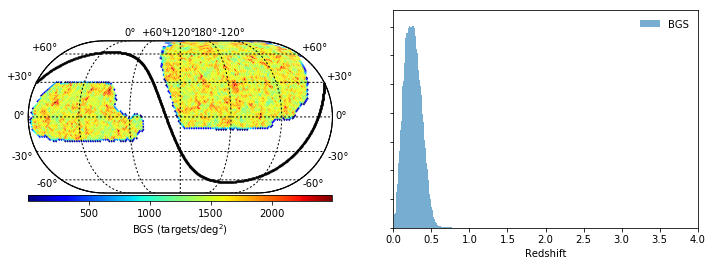

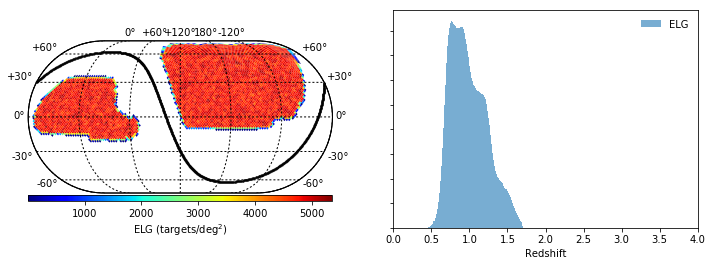

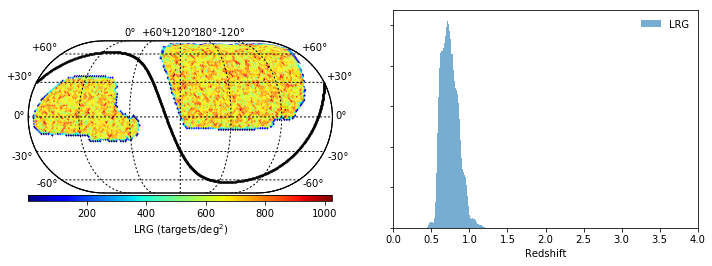

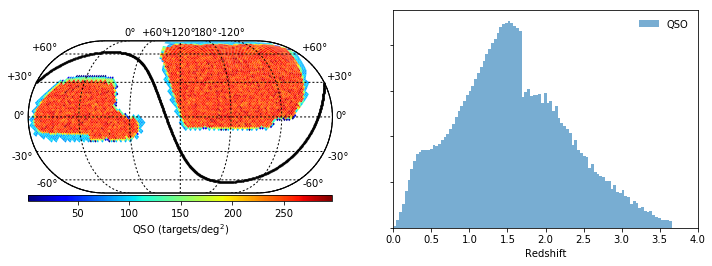

In [29]:
for obj in ('BGS', 'ELG', 'LRG', 'QSO'):
    qamock_sky(data[obj], obj)

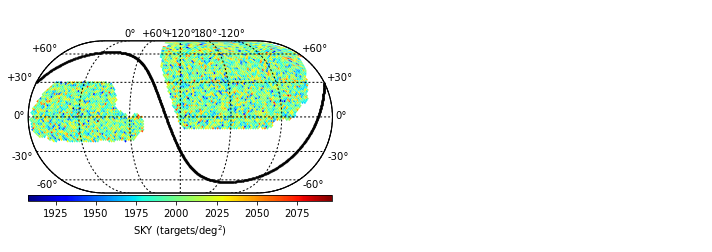

In [30]:
for obj in np.atleast_1d('SKY'):
    qamock_sky(data[obj], obj)

### 1c) Clean up to free up memory.

In [31]:
del data

### 2a) Generate the target and truth catalogs.

In [32]:
def write_yaml(bounds=(203, 204, 0, 1), outfile='mock_input.yaml', verbose=False):
    """Write a yaml file on-the-fly for *all* target types."""
    log.info('Writing {}'.format(outfile))
    yf = open(outfile, 'w')
    yf.write('dust_dir: {}\n'.format(os.path.join(os.getenv('DUST_DIR'), 'maps')))
    yf.write('decals_brick_info: {}\n'.format(os.path.join(os.getenv('DESI_ROOT'), 'target', 
                                                           'catalogs', 'brick-info-dr3.v0.0.1.fits')))
    yf.write('subset:\n')
    yf.write('    ra_dec_cut: True\n')
    for blabel, bbound in zip(('min_ra', 'max_ra', 'min_dec', 'max_dec'), bounds):
        yf.write('    {}: {:g}\n'.format(blabel, bbound))
    yf.write('sources:\n')
    yf.write('    BGS: {\n')
    yf.write('        target_name: BGS,\n')
    yf.write('        mock_dir_name: {},\n'.format(_BGSpath()))
    yf.write('        format: durham_mxxl_hdf5,\n')
    yf.write('        magcut: 20.3,\n')
    yf.write('        contam: {\n')
    yf.write('            STAR: 50,\n')
    yf.write('        }\n')
    yf.write('    }\n')
    yf.write('    ELG: {\n')
    yf.write('        target_name: ELG,\n')
    yf.write('        mock_dir_name: {},\n'.format(_GRFpath(objtype='ELG')))
    yf.write('        format: gaussianfield,\n')
    yf.write('        density: 2155,\n')
    yf.write('        contam: {\n')
    yf.write('            STAR: 240,\n')
    yf.write('        }\n')
    yf.write('    }\n')
    yf.write('    FAINTSTAR: {\n')
    yf.write('        target_name: FAINTSTAR,\n')
    yf.write('        mock_dir_name: {},\n'.format(_mwspath(faint=True)))
    yf.write('        format: galaxia,\n')
    yf.write('        magcut: 23.5\n')
    yf.write('    }\n')
    yf.write('    LRG: {\n')
    yf.write('        target_name: LRG,\n')
    yf.write('        mock_dir_name: {},\n'.format(_GRFpath(objtype='LRG')))
    yf.write('        format: gaussianfield,\n')
    yf.write('        density: 350,\n')
    yf.write('    }\n')
    yf.write('    MWS_MAIN: {\n')
    yf.write('        target_name: MWS_MAIN,\n')
    yf.write('        mock_dir_name: {},\n'.format(_mwspath()))
    yf.write('        format: galaxia,\n')
    yf.write('    }\n')
    yf.write('    MWS_NEARBY: {\n')
    yf.write('        target_name: MWS_NEARBY,\n')
    yf.write('        mock_dir_name: {},\n'.format(_mwspath(nearby=True)))
    yf.write('        format: 100pc,\n')
    yf.write('    }\n')
    yf.write('    MWS_WD: {\n')
    yf.write('        target_name: MWS_WD,\n')
    yf.write('        mock_dir_name: {},\n'.format(_mwspath(WD=True)))
    yf.write('        format: wd,\n')
    yf.write('    }\n')
    yf.write('    QSO: {\n')
    yf.write('        target_name: QSO,\n')
    yf.write('        mock_dir_name: {},\n'.format(_GRFpath(objtype='QSO')))
    yf.write('        format: gaussianfield,\n')
    yf.write('        density: 120,\n')
    yf.write('        contam: {\n')
    yf.write('            GALAXY: 27,\n')
    yf.write('            STAR: 63,\n')
    yf.write('        },\n')
    yf.write('        LYA: {\n')
    yf.write('            mock_dir_name: {},\n'.format(_lyapath()))
    yf.write('            density: 50,\n')
    yf.write('            zcut: 2.1,\n')
    yf.write('        }\n')
    yf.write('    }\n')
    yf.write('    SKY: {\n')
    yf.write('        target_name: SKY,\n')
    yf.write('        mock_dir_name: {},\n'.format(_GRFpath(sky=True)))
    yf.write('        format: gaussianfield,\n')
    yf.write('        density: 1400,\n')
    yf.write('    }\n')
    yf.close()    
    if verbose:
        print()
        with(open(outfile, 'r')) as yf:
            print(yf.read())

In [34]:
def build_targets_truth(prefix='qatargets', seed=555, nproc=4, verbose=True, 
                        bounds=(203, 204, 1, 2), bricksize=0.25, output_dir=None):
    """Simple wrapper on desitarget.mock.targets_truth.
    
    Prefix can also optionally be an object type (e.g., ELG).
    """
    from desitarget.mock.build import targets_truth
    
    if output_dir is None:
        output_dir = os.path.join(mockpath, '{}'.format(prefix))
    try:
        os.stat(output_dir)
    except:
        os.makedirs(output_dir)

    config_file = os.path.join(mockpath, '{}_input.yaml'.format(prefix))
    write_yaml(bounds=bounds, outfile=config_file, verbose=verbose)
    
    with open(config_file, 'r') as pfile:
        params = yaml.load(pfile)
    targets_truth(params, output_dir, seed=seed, verbose=verbose, nproc=nproc, 
                  bricksize=bricksize, outbricksize=bricksize)

In [35]:
# Specify root path and the (ra,dec) boundaries.
prefix = 'qatargets'
mockpath = os.path.join(os.getenv('DESI_ROOT'), 'datachallenge', prefix)
radec_bounds = (203, 204, 1, 2)

In [36]:
# Build the mock catalogs.
build_targets_truth(seed=555, bounds=radec_bounds, prefix=prefix)

INFO:<ipython-input-32-2fab6e2b469e>:3:write_yaml: Writing /Users/ioannis/research/projects/desi/datachallenge/qatargets/qatargets_input.yaml

dust_dir: /Users/ioannis/research/data/sfd_dustmaps/maps
decals_brick_info: /Users/ioannis/research/projects/desi/target/catalogs/brick-info-dr3.v0.0.1.fits
subset:
    ra_dec_cut: True
    min_ra: 203
    max_ra: 204
    min_dec: 1
    max_dec: 2
sources:
    BGS: {
        target_name: BGS,
        mock_dir_name: /Users/ioannis/research/projects/desi/mocks/bgs/MXXL/desi_footprint/v0.0.3/BGS.hdf5,
        format: durham_mxxl_hdf5,
        magcut: 20.3,
        contam: {
            STAR: 50,
        }
    }
    ELG: {
        target_name: ELG,
        mock_dir_name: /Users/ioannis/research/projects/desi/mocks/GaussianRandomField/v0.0.5/ELG.fits,
        format: gaussianfield,
        density: 2155,
        contam: {
            STAR: 240,
        }
    }
    FAINTSTAR: {
        target_name: FAINTSTAR,
        mock_dir_name: /Users/ioannis/rese

/Users/ioannis/repos/desihub/desitarget/py/desitarget/QA.py:72: RuntimeWarning: fluctuations for targettype MWS_WD are set to one
  warnings.warn(mess, RuntimeWarning)
/Users/ioannis/repos/desihub/desitarget/py/desitarget/QA.py:72: RuntimeWarning: fluctuations for targettype FAINTSTAR are set to one
  warnings.warn(mess, RuntimeWarning)
/Users/ioannis/repos/desihub/desitarget/py/desitarget/QA.py:72: RuntimeWarning: fluctuations for targettype MWS_NEARBY are set to one
  warnings.warn(mess, RuntimeWarning)
/Users/ioannis/repos/desihub/desitarget/py/desitarget/QA.py:72: RuntimeWarning: fluctuations for targettype MWS_MAIN are set to one
  warnings.warn(mess, RuntimeWarning)
/Users/ioannis/repos/desihub/desitarget/py/desitarget/QA.py:72: RuntimeWarning: fluctuations for targettype SKY are set to one
  warnings.warn(mess, RuntimeWarning)
/Users/ioannis/repos/desihub/desitarget/py/desitarget/QA.py:72: RuntimeWarning: fluctuations for targettype MWS_WD are set to one
  warnings.warn(mess, Ru

INFO:build.py:494:targets_truth: Initializing the MockSpectra and SelectTargets classes.
INFO:io.py:613:read_basis_templates: Reading /Users/ioannis/research/projects/desi/spectro/templates/basis_templates/v2.3/bgs_templates_v2.1.fits metadata.
INFO:io.py:613:read_basis_templates: Reading /Users/ioannis/research/projects/desi/spectro/templates/basis_templates/v2.3/elg_templates_v2.0.fits metadata.
INFO:io.py:613:read_basis_templates: Reading /Users/ioannis/research/projects/desi/spectro/templates/basis_templates/v2.3/lrg_templates_v1.3.fits metadata.
INFO:io.py:613:read_basis_templates: Reading /Users/ioannis/research/projects/desi/spectro/templates/basis_templates/v2.3/star_templates_v2.1.fits metadata.
INFO:io.py:613:read_basis_templates: Reading /Users/ioannis/research/projects/desi/spectro/templates/basis_templates/v2.3/qso_templates_v2.0.fits metadata.
INFO:io.py:613:read_basis_templates: Reading /Users/ioannis/research/projects/desi/spectro/templates/basis_templates/v2.3/wd_templ

INFO:build.py:433:write_onebrick: Writing /Users/ioannis/research/projects/desi/datachallenge/qatargets/qatargets/203/truth-2031p015.fits.
INFO:build.py:433:write_onebrick: Writing /Users/ioannis/research/projects/desi/datachallenge/qatargets/qatargets/203/truth-2031p012.fits.
INFO:build.py:433:write_onebrick: Writing /Users/ioannis/research/projects/desi/datachallenge/qatargets/qatargets/203/truth-2031p017.fits.


INFO:build.py:433:write_onebrick: Writing /Users/ioannis/research/projects/desi/datachallenge/qatargets/qatargets/203/truth-2038p010.fits.
INFO:build.py:433:write_onebrick: Writing /Users/ioannis/research/projects/desi/datachallenge/qatargets/qatargets/203/truth-2036p017.fits.
INFO:build.py:433:write_onebrick: Writing /Users/ioannis/research/projects/desi/datachallenge/qatargets/qatargets/203/truth-2036p015.fits.
INFO:build.py:433:write_onebrick: Writing /Users/ioannis/research/projects/desi/datachallenge/qatargets/qatargets/203/truth-2036p010.fits.
INFO:build.py:433:write_onebrick: Writing /Users/ioannis/research/projects/desi/datachallenge/qatargets/qatargets/203/truth-2033p017.fits.
Writing 5 bricks; 7.2 bricks / sec
INFO:build.py:433:write_onebrick: Writing /Users/ioannis/research/projects/desi/datachallenge/qatargets/qatargets/203/truth-2038p012.fits.
INFO:build.py:433:write_onebrick: Writing /Users/ioannis/research/projects/desi/datachallenge/qatargets/qatargets/203/truth-2038p02

### 2b) Sanity check the output files.

In [37]:
def get_targtruth_files(prefix='qatargets'):
    output_dir = os.path.join(mockpath, '{}'.format(prefix))
    targfiles = glob(os.path.join(output_dir, '???', 'targets-*.fits'))#[:1]
    truthfiles = glob(os.path.join(output_dir, '???', 'truth-*.fits'))#[:1]
    return targfiles, truthfiles

In [38]:
def sanity_check_files(prefix='qatargets'):
    """Simple script to do some basic sanity checks of the files on disk."""
    targfiles, truthfiles = get_targtruth_files(prefix)
    log.info('Sanity checking {} target and {} truth files in directory {}.'.format(
        len(targfiles), len(truthfiles), prefix))
             
    if len(targfiles) != len(truthfiles):
        log.warning('Mismatch in the number of target (N={}) and truth (N={}) files!').format(
            len(targfiles), len(truthfiles))

    for targfile, truthfile in zip(np.atleast_1d(targfiles), np.atleast_1d(truthfiles)):
        targ = fitsio.FITS(targfile)
        truth = fitsio.FITS(truthfile)
        ntarg = targ[1].get_nrows()
        ntruth = truth[2].get_nrows()
        wave_dims = truth[0].get_dims()
        flux_dims = truth[1].get_dims()

        if (ntarg != ntruth):
            log.warning('{}: {} objects in TRUTH table, {} objects in TARGETS table.'.format(
                os.path.basename(targfile), ntruth, ntarg))

        if (flux_dims[0] != ntarg):
            log.warning('{}: {} objects in TRUTH table, {} spectra.'.format(
                os.path.basename(targfile), ntruth, flux_dims[0]))
            
        if (flux_dims[1] != wave_dims[0]):
            log.warning('{}}: {} pixels in wavelength vector, {} pixels in flux spectra.'.format(
                os.path.basename(targfile), wave_dims[0], flux_dims[1]))

In [39]:
sanity_check_files(prefix)

INFO:<ipython-input-38-39fe683ca49b>:5:sanity_check_files: Sanity checking 20 target and 20 truth files in directory qatargets.


### Read the data and derive the target densities.

In [40]:
def read_targets_truth(prefix):
    """Simple wrapper script to gather up all the target and truth catalogs."""
    targfiles, truthfiles = get_targtruth_files(prefix)
    targets, truth = [], []
    for targfile, truthfile in zip(np.atleast_1d(targfiles), np.atleast_1d(truthfiles)):
        targets.append(Table(fitsio.read(targfile, ext=1)))
        truth.append(Table(fitsio.read(truthfile, ext=2)))
    targets = vstack(targets)
    truth = vstack(truth)
    log.info('Read {} targets from {} bricks.'.format(len(targets), len(targfiles)))
    return targets, truth

In [41]:
def target_density(prefix, targets, truth):
    """Determine the target density of each object type (including contaminants)."""
    
    bricksize = 0.25
    brickarea = bricksize**2 # deg2
    
    allbricks = targets['BRICKNAME'].data
    ubricks = set(allbricks)
    nbrick = len(ubricks)
    
    density = Table()
    density.add_column(Column(name='BRICKNAME', length=nbrick, dtype='U10'))
    # ELGs
    density.add_column(Column(name='ELG_TARGETS', length=nbrick, dtype='f4'))
    density.add_column(Column(name='ELG_IS_RIGHTZ', length=nbrick, dtype='f4'))
    density.add_column(Column(name='ELG_IS_LOZ', length=nbrick, dtype='f4'))
    density.add_column(Column(name='ELG_IS_HIZ', length=nbrick, dtype='f4'))
    density.add_column(Column(name='ELG_IS_STAR', length=nbrick, dtype='f4'))
    density.add_column(Column(name='ELG_IS_QSO', length=nbrick, dtype='f4'))
    # QSOs
    density.add_column(Column(name='QSO_TARGETS', length=nbrick, dtype='f4'))
    density.add_column(Column(name='QSO_IS_GALAXY', length=nbrick, dtype='f4'))
    density.add_column(Column(name='QSO_IS_STAR', length=nbrick, dtype='f4'))

    for ii, brick in enumerate(ubricks):
        density['BRICKNAME'][ii] = brick
        # ELGs
        onbrick = brick == allbricks

        elg = onbrick * ( (targets['DESI_TARGET'] & desi_mask.mask('ELG')) != 0 )
        density['ELG_TARGETS'][ii] = np.sum( elg ) / brickarea
        
        density['ELG_IS_RIGHTZ'][ii] = np.sum( elg * 
                                              (truth['TRUEZ'] > 0.6) * 
                                              (truth['TRUEZ'] < 1.6) 
                                             ) / brickarea
        density['ELG_IS_LOZ'][ii] = np.sum( elg * (truth['TRUEZ'] < 0.6)) / brickarea
        density['ELG_IS_HIZ'][ii] = np.sum( elg * (truth['TRUEZ'] > 1.6)) / brickarea
        density['ELG_IS_STAR'][ii] = np.sum( elg * 
                                            ( (truth['CONTAM_TARGET'] & contam_mask.mask('ELG_IS_STAR')) != 0 )
                                           ) / brickarea
        density['ELG_IS_QSO'][ii] = np.sum( elg * 
                                           ( (truth['CONTAM_TARGET'] & contam_mask.mask('ELG_IS_QSO')) != 0 )
                                          ) / brickarea
        
        # QSOs
        qso = onbrick * ( (targets['DESI_TARGET'] & desi_mask.mask('QSO')) != 0 )
        density['QSO_TARGETS'][ii] = np.sum( qso ) / brickarea
        density['QSO_IS_GALAXY'][ii] = np.sum( qso * 
                                           ( (truth['CONTAM_TARGET'] & contam_mask.mask('QSO_IS_GALAXY')) != 0 )
                                          ) / brickarea
        density['QSO_IS_STAR'][ii] = np.sum( qso * 
                                           ( (truth['CONTAM_TARGET'] & contam_mask.mask('QSO_IS_STAR')) != 0 )
                                          ) / brickarea

    return density

In [42]:
targets, truth = read_targets_truth(prefix)

INFO:<ipython-input-40-26f6e3b92bf9>:10:read_targets_truth: Read 5751 targets from 20 bricks.


In [43]:
density = target_density(prefix, targets, truth)

### 2c) Make a variety of QAplots.

In [44]:
def _grlim():
    return (-0.5, 2.0)

In [45]:
def _rzlim():
    return (-0.5, 2.2)

In [46]:
def _rW1lim():
    return (-2, 6)

In [47]:
def _grzrange():
    return (16, 24)

In [48]:
def _rmagrange(qso=None):
    rmagrange = (16, 24)
    if qso:
        drmag = 0.2
    else:
        drmag = 0.1
    nrmagbins = int((rmagrange[1] - rmagrange[0]) / drmag)
    return rmagrange, nrmagbins

In [49]:
def flux2colors(cat):
    """Convert DECam/WISE fluxes to magnitudes and colors."""
    colors = dict()
    with warnings.catch_warnings(): # ignore missing fluxes (e.g., for QSOs)
        warnings.simplefilter('ignore')
        for ii, band in zip((1, 2, 4), ('g', 'r', 'z')):
            colors[band] = 22.5 - 2.5 * np.log10(cat['DECAM_FLUX'][..., ii].data)
        for ii, band in zip((0, 1), ('W1', 'W2')):
            colors[band] = 22.5 - 2.5 * np.log10(cat['WISE_FLUX'][..., ii].data)
        colors['grz'] = 22.5-2.5*np.log10((cat['DECAM_FLUX'][..., 1] + 
                                           0.8 * cat['DECAM_FLUX'][..., 2] +
                                           0.5 * cat['DECAM_FLUX'][..., 4]).data / 2.3)
        colors['W'] = 22.5-2.5*np.log10(0.75 * cat['WISE_FLUX'][..., 0] + 
                                        0.25 * cat['WISE_FLUX'][..., 1]) # for QSOs

    colors['gr'] = colors['g'] - colors['r']
    colors['rz'] = colors['r'] - colors['z']
    colors['rW1'] = colors['r'] - colors['W1']
    colors['W1W2'] = colors['W1'] - colors['W2']
    
    return colors

In [50]:
def elg_colorbox(ax):
    """Draw the ELG selection box."""
    rmaglim = 23.4
    grlim = ax.get_ylim()
    coeff0, coeff1 = (1.15, -0.15), (-1.2, 1.6)
    rzmin, rzpivot = 0.3, (coeff1[1] - coeff0[1]) / (coeff0[0] - coeff1[0])
    verts = [(rzmin, grlim[0]),
             (rzmin, np.polyval(coeff0, rzmin)),
             (rzpivot, np.polyval(coeff1, rzpivot)),
             ((grlim[0] - 0.1 - coeff1[1]) / coeff1[0], grlim[0] - 0.1)
            ]
    ax.add_patch(Polygon(verts, fill=False, ls='--', color='k'))
    return rmaglim

In [51]:
def qso_colorbox(ax, plottype='grz'):
    """Draw the QSO selection boxes."""
    rmaglim = 22.7
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    if plottype == 'grz-r':
        verts = [(xlim[0]-0.05, 17.0),
                 (22.7, 17.0),
                 (22.7, ylim[1]+0.05),
                 (xlim[0]-0.05, ylim[1]+0.05)
                ]
    if plottype == 'rW1-rz':
        verts = None
        ax.axvline(x=-0.3, ls='--', color='k')
        ax.axvline(x=1.3, ls='--', color='k')

    if plottype == 'gr-rz':
        verts = [(-0.3, 1.3),
                 (1.1, 1.3),
                 (1.1, ylim[0]-0.05),
                 (-0.3, ylim[0]-0.05)
                ]
    if verts:
        ax.add_patch(Polygon(verts, fill=False, ls='--', color='k'))

In [52]:
def qaplot_qso_colormag(targets, truth=None, contam=False):
    """Make a few different color-color plots for QSOs."""
    
    objtype = 'QSO'
    
    iobj = np.where((targets['DESI_TARGET'] & desi_mask.mask(objtype)) != 0)[0]
    if truth:
        cat = flux2colors(truth[iobj])
    else:
        cat = flux2colors(targets[iobj])

    fig, ax = plt.subplots(1, 3, figsize=(14, 4))

    if contam:
        for cc in np.atleast_1d(contam):
            these = np.where(truth['TEMPLATETYPE'].data[iobj] == bytes(cc, 'utf-8'))[0]
            if len(these) > 0:
                ax[0].scatter(cat['rz'][these], cat['gr'][these], 
                              s=10, alpha=0.7, label=cc)
            ax[0].legend(loc='upper right')
    else:
        ax[0].scatter(cat['rz'], cat['gr'], s=10, alpha=0.7)
    ax[0].set_xlabel('$r - z$')
    ax[0].set_ylabel('$g - r$')
    ax[0].set_xlim(_rzlim())
    ax[0].set_ylim(_grlim())
    qso_colorbox(ax[0], 'gr-rz')

    if contam:
        for cc in np.atleast_1d(contam):
            these = np.where(truth['TEMPLATETYPE'].data[iobj] == bytes(cc, 'utf-8'))[0]
            if len(these) > 0:
                ax[1].scatter(cat['r'][these], cat['grz'][these], 
                              s=10, alpha=0.7, label=cc)
    else:
        ax[1].scatter(cat['r'], cat['grz'], s=10, alpha=0.7)
    ax[1].set_xlabel('$r$')
    ax[1].set_ylabel('$grz$')
    ax[1].set_xlim(_rmagrange()[0])
    ax[1].set_ylim(_grzrange())
    qso_colorbox(ax[1], 'grz-r')
    
    magrange, nbins = _rmagrange(qso=1)
    nn, bins, _ = ax[2].hist(cat['r'], bins=nbins, range=magrange, align='mid')
    ax[2].axvline(x=22.7, ls='--', color='red')
    ax[2].set_xlabel('r')
    ax[2].set_ylabel('Number of Objects')
    
    if truth:
        plt.suptitle('{} - All Targets, True Photometry'.format(objtype.upper()))
    else:
        plt.suptitle('{} - All Targets, Observed Photometry'.format(objtype.upper()))
        
    fig.subplots_adjust(wspace=0.3)

In [53]:
def qaplot_elg_colormag(targets, truth=None, contam=False):
    """Make a few different color-color plots for ELGs."""
    
    objtype = 'ELG'
    
    iobj = np.where((targets['DESI_TARGET'] & desi_mask.mask(objtype)) != 0)[0]
    if truth:
        cat = flux2colors(truth[iobj])
    else:
        cat = flux2colors(targets[iobj])

    fig, ax = plt.subplots(1, 2, figsize=(8, 3))

    if contam:
        for cc in np.atleast_1d(contam):
            these = np.where(truth['TEMPLATETYPE'].data[iobj] == bytes(cc, 'utf-8'))[0]
            if len(these) > 0:
                ax[0].scatter(cat['rz'][these], cat['gr'][these], 
                              s=10, alpha=0.7, label=cc)
            ax[0].legend(loc='upper right')
    else:
        ax[0].scatter(cat['rz'], cat['gr'], s=10, alpha=0.7)
    ax[0].set_xlabel('$r - z$')
    ax[0].set_ylabel('$g - r$')
    ax[0].set_xlim(_rzlim())
    ax[0].set_ylim(_grlim())
    elg_colorbox(ax[0])

    magrange, nbins = _rmagrange()
    nn, bins, _ = ax[1].hist(cat['r'], bins=nbins, range=magrange, align='mid')
    ax[1].axvline(x=23.4, ls='--', color='red')
    ax[1].set_xlabel('r')
    ax[1].set_ylabel('Number of Objects')
    
    if truth:
        plt.suptitle('{} - All Targets, True Photometry'.format(objtype.upper()))
    else:
        plt.suptitle('{} - All Targets, Observed Photometry'.format(objtype.upper()))
        
    fig.subplots_adjust(wspace=0.3)

In [54]:
def qaplot_elg_density(density, mockdensity):
    """Visualize the ELG target densities, including contaminants."""
    bins = 15
    dens_all = 2400
    dens_loz = dens_all*0.05
    dens_hiz = dens_all*0.05
    dens_star = dens_all*0.1
    dens_rightz = dens_all - dens_loz - dens_hiz - dens_star
    
    fig, ax = plt.subplots(1, 5, figsize=(16, 3.5))

    ax[0].hist(mockdensity['ELG'], bins=bins, #range=(mn, mx), 
                normed=True, label=['Input Mock'])
    ax[0].yaxis.set_major_formatter(plt.NullFormatter())
    ax[0].legend(loc='upper left')

    mn, mx = dens_all*0.4, dens_all*1.1
    ax[1].hist(density['ELG_TARGETS'], bins=bins, #range=(mn, mx), 
               normed=True, label=['All Targets'])
    ax[1].set_xlim(mn, mx)
    ax[1].yaxis.set_major_formatter(plt.NullFormatter())
    ax[1].axvline(x=dens_all, ls='--', color='k')
    ax[1].legend(loc='upper right')

    mn, mx = dens_rightz*0.4, dens_rightz*1.1
    ax[2].hist(density['ELG_IS_RIGHTZ'], bins=bins, #range=(mn, mx), 
               normed=True, label=['ELG 0.6<z<1.6'], alpha=0.5)
    ax[2].set_xlim(mn, mx)
    ax[2].yaxis.set_major_formatter(plt.NullFormatter())
    ax[2].axvline(x=dens_rightz, ls='--', color='k')
    ax[2].legend(loc='upper right')
    
    ax[3].hist(density['ELG_IS_LOZ'], bins=bins//2, #range=contam_range, 
               alpha=0.6, label=['ELG z<0.6'], 
               ls='--', lw=2)
    ax[3].hist(density['ELG_IS_HIZ'], bins=bins//2, #range=contam_range,
               alpha=0.3, label=['ELG z>1.6'], 
               ls='-', lw=2)
    ax[3].hist(density['ELG_IS_QSO'], bins=bins//2, #range=contam_range,
               alpha=0.3, label=['ELG is QSO'], 
               ls='-', lw=2)
    ax[3].yaxis.set_major_formatter(plt.NullFormatter())
    ax[3].axvline(x=dens_loz, ls='--', color='k')
    ax[3].legend(loc='upper right')  
    
    mn, mx = dens_star*0.4, dens_star*1.1
    ax[4].hist(density['ELG_IS_STAR'], bins=bins//2, #range=contam_range,
               label=['ELG is STAR'])
    ax[4].set_xlim(mn, mx)
    ax[4].yaxis.set_major_formatter(plt.NullFormatter())
    ax[4].axvline(x=dens_star, ls='--', color='k')
    ax[4].legend(loc='upper left')
    
    for thisax in ax:
        thisax.set_xlabel('Targets / deg$^{2}$')
    ax[0].set_ylabel('Normalized Number')
    
    plt.suptitle('ELG')
    fig.subplots_adjust(wspace=0.1)

In [55]:
def qaplot_qso_density(density, mockdensity):
    """Visualize the QSO (tracer + Lya) target densities, including contaminants."""
    bins = 15
    dens_all = 120
    dens_star = 63
    dens_galaxy = 27
    contam_range = (0, dens_star*1.2)

    fig, ax = plt.subplots(1, 4, figsize=(12, 3))
    ax[0].hist(mockdensity['QSO'], bins=bins, #range=(mn, mx), 
                normed=True, label=['Input Mock'])
    ax[0].yaxis.set_major_formatter(plt.NullFormatter())
    ax[0].legend(loc='upper left')
    
    ax[1].hist(density['QSO_TARGETS'], bins=bins, range=(dens_all-40, dens_all+40), 
               label=['All Targets'])
    ax[1].axvline(x=dens_all, ls='--', color='k')
    ax[1].yaxis.set_major_formatter(plt.NullFormatter())
    ax[1].legend(loc='upper right')

    ax[2].hist(density['QSO_IS_STAR'], bins=bins, range=contam_range, 
               label=['QSO is STAR'], 
               ls='--', lw=2)
    ax[2].axvline(x=dens_star, ls='--', color='k')
    ax[2].yaxis.set_major_formatter(plt.NullFormatter())
    ax[2].legend(loc='upper right')  
    
    ax[3].hist(density['QSO_IS_GALAXY'], bins=bins, range=contam_range,
               label=['QSO is GALAXY'])
    ax[3].axvline(x=dens_galaxy, ls='--', color='k')
    ax[3].yaxis.set_major_formatter(plt.NullFormatter())
    ax[3].legend(loc='upper right')
   
    for thisax in ax:
        thisax.set_xlabel('Targets / deg$^{2}$')
    ax[0].set_ylabel('Normalized Number')
    
    plt.suptitle('QSO')
    fig.subplots_adjust(wspace=0.1)

In [56]:
def qaplot_targets_skymap(cat, objtype):
    fig, ax = plt.subplots()
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        basemap = init_sky(galactic_plane_color='k', ax=ax);
        plot_sky_binned(cat['RA'], cat['DEC'], verbose=False, 
                        clip_lo='!1', cmap='jet', plot_type='healpix', 
                        label=r'{} (targets/deg$^2$)'.format(objtype), 
                        basemap=basemap)

In [57]:
def qaplot_targets_sky(targets, truth, objtype='ELG', contam=None):
    iobj = np.where((targets['DESI_TARGET'] & desi_mask.mask(objtype)) != 0)[0]
    fig, ax = plt.subplots()
    if contam:
        for cc in np.atleast_1d(contam):
            these = np.where(truth['TEMPLATETYPE'].data[iobj] == bytes(cc, 'utf-8'))[0]
            if len(these) > 0:
                ax.scatter(targets['RA'][iobj][these], targets['DEC'][iobj][these], 
                              s=10, alpha=0.7, label=cc)
                ax.legend(loc='upper right')
    else:
        ax.scatter(targets['RA'][iobj], targets['DEC'][iobj], 
                      s=10, alpha=0.7)
        ax.set_title(objtype.upper())

#### ELGs.

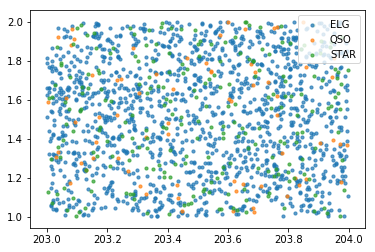

In [58]:
objtype = 'ELG'
qaplot_targets_sky(targets, truth, objtype, contam=('ELG', 'QSO', 'STAR'))

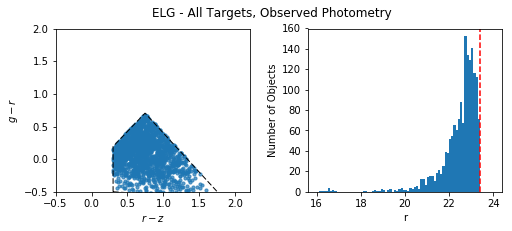

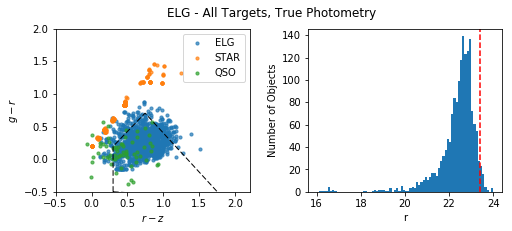

In [60]:
# Would be nice if the color-color plots were color-coded by r-band magnitude.
qaplot_elg_colormag(targets)                                             # All targets, observed (noisy) photometry.
qaplot_elg_colormag(targets, truth=truth, contam=['ELG', 'STAR', 'QSO']) # All targets, true (noiseless) photometry.

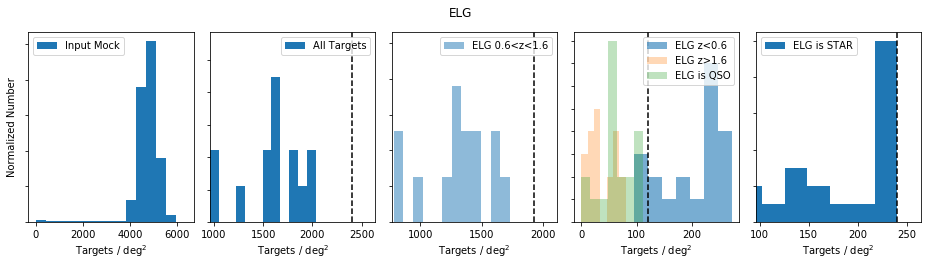

In [61]:
qaplot_elg_density(density, mockdensity)

#### QSOs

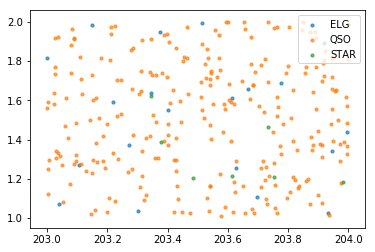

In [62]:
objtype = 'QSO'
qaplot_targets_sky(targets, truth, objtype, contam=('ELG', 'QSO', 'STAR'))

/usr/local/anaconda3/envs/desi/lib/python3.5/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/usr/local/anaconda3/envs/desi/lib/python3.5/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)
/usr/local/anaconda3/envs/desi/lib/python3.5/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in subtract


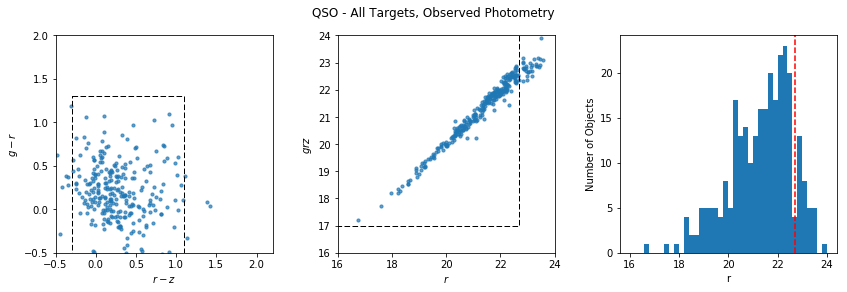

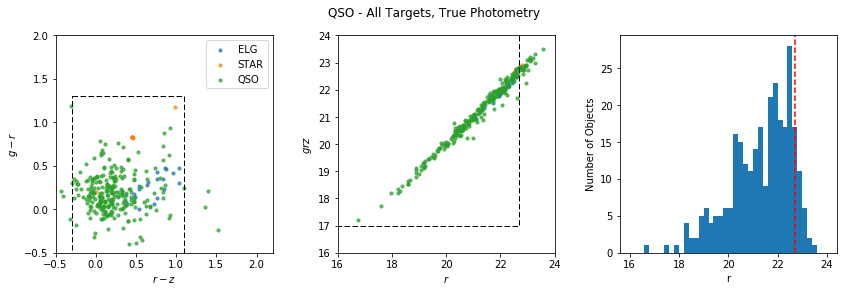

In [63]:
qaplot_qso_colormag(targets)                                             # All targets, observed (noisy) photometry.
qaplot_qso_colormag(targets, truth=truth, contam=['ELG', 'STAR', 'QSO']) # Contaminants.

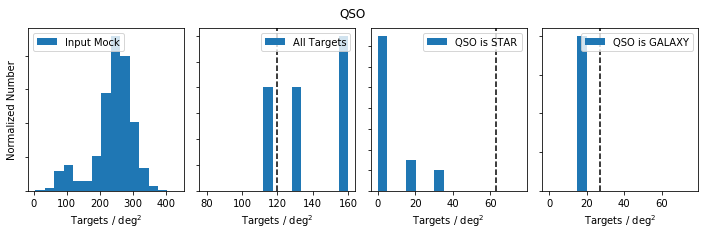

In [64]:
qaplot_qso_density(density, mockdensity)